In [ ]:
%matplotlib qt

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#@np.vectorize
def calculatePensionAndLoan(pension,studentLoan,months,m,x,y,interestPension,interestStudentLoan,alpha):
    #m monthly income
    #x fraction overall income towards pension and student loans
    #y fraction of x towards pensions
    #alpha employer contribution as percentage
    #pension total pension
    #studentLoan student loans left to pay
    
    pensionVals = np.zeros(months)
    studentLoanVals = np.zeros(months)
    paymentsToLoans = np.zeros(months)
    paymentsToPension = np.zeros(months)
    monthVals = np.arange(1,months+1,1)
    pensionVals[0] = pension
    studentLoanVals[0] = studentLoan
    paymentsToLoans[0] = 0
    paymentsToPension[0] = 0
    
    for i in range(1,months):
        
        pensionPayment = 0
        loanPayment = 0
        
        #if student loan is paid or been 30 years, put the money towards pension
        if i > 360:
            pensionPayment += m*x*(1-y)
            loanPayment = 0
            studentLoan = 0
        elif studentLoan - m*x*(1-y) < 0: #if last payment to student loan, put money towards pension
            pensionPayment += m*x*(1-y) - studentLoan
            loanPayment = studentLoan
        else: #make payment to student loan
            loanPayment = m*x*(1-y)
            
        studentLoan -= loanPayment 
        
        pensionPayment += m*x*y + m*alpha/100
        pension += pensionPayment
        
        #add interest
        pension *= interestPension
        studentLoan *= interestStudentLoan
        
        pensionVals[i] = pension
        studentLoanVals[i] = studentLoan
        
        paymentsToLoans[i] = paymentsToLoans[i-1] + loanPayment
        paymentsToPension[i] = paymentsToPension[i-1] + pensionPayment
        
    return [monthVals,pensionVals,studentLoanVals,paymentsToLoans,paymentsToPension]
    


In [ ]:
def calculateFinances(
    pension,
    loan,
    investment,
    totalMonths,
    initialAnnualGrossSalary,
    finalAnnualGrossSalary,
    percentagePensionPayment,
    percentageLoanPayment,
    percentageInvestmentPayment,
    employerPercentageContribution,    
    monthlyLoanMultiplier,
    monthlyPensionMultiplier,
    monthlyInvestmentMultiplier,
    isStudentLoan=False,
    loanMonthsLeft=0):
    
    loans = np.zeros(totalMonths)
    pensions = np.zeros(totalMonths)
    investments = np.zeros(totalMonths)
    loanPayments = np.zeros(totalMonths)
    pensionPayments = np.zeros(totalMonths)
    investmentPayments = np.zeros(totalMonths)
    taxedPensions = np.zeros(totalMonths)
    
    loans[0] = loan
    pensions[0] = pension
    investments[0] = investment
    
    for i in range(1,totalMonths):
        annualSalary = calculateLinearSalary(initialAnnualGrossSalary,finalAnnualGrossSalary,totalMonths,i)
        monthlyLoanPayment = (percentageLoanPayment/100)*(annualSalary/12)
        monthlyPensionPayment = (percentagePensionPayment/100)*(annualSalary/12)
        monthlyInvestmentPayment = (percentageInvestmentPayment/100)*(annualSalary/12)
        employerMonthlyContribution = (employerPercentageContribution/100)*(annualSalary/12)
        
        [loan,spare] = calculateLoan(loan,monthlyLoanPayment,monthlyLoanMultiplier,isStudentLoan,loanMonthsLeft)
        if loanMonthsLeft > 0:
            loanMonthsLeft -= 1
        pension = calculatePension(pension,monthlyPensionPayment+spare,monthlyPensionMultiplier,employerMonthlyContribution)
        investment = calculateInvestment(investment,monthlyInvestmentPayment,monthlyInvestmentMultiplier)
        
        loans[i] = loan
        pensions[i] = pension
        investments[i] = investment
        loanPayments[i] = loanPayments[i-1] + monthlyLoanPayment-spare
        pensionPayments[i] = pensionPayments[i-1] + monthlyPensionPayment+spare
        investmentPayments[i] = investmentPayments[i-1] + monthlyInvestmentPayment
        taxedPensions[i] = calculateTaxedPension(pension,annualSalary)
        
    return [pensions,loans,investments,loanPayments,pensionPayments,investmentPayments,taxedPensions]
    

In [ ]:
#Calculates the minimum monthly repayment for the given annual income
def calcMinStudentRepayment(annualIncome):
    if annualIncome <= 25000:
        monthlyPayment = 0
    else:
        monthlyPayment = (annualIncome - 25000)*0.09/12
        
    return monthlyPayment

In [ ]:
def calculateLoan(loan,monthlyPayment,monthlyMultiplier,isStudentLoan=False,loanMonthsLeft=0):
    if (isStudentLoan and loanMonthsLeft == 0):
        loan = 0
        spare = monthlyPayment
    else:
        if monthlyPayment > loan:
            loan = 0
            spare = monthlyPayment - loan
        else:
            loan -= monthlyPayment
            spare = 0

        loan *= monthlyMultiplier
        
    return [loan,spare]

In [ ]:
def calculatePension(pension,monthlyPayment,monthlyMultiplier,employerMonthlyContribution):
    pension = (pension+monthlyPayment+employerMonthlyContribution)*monthlyMultiplier
    return pension

In [ ]:
def calculateInvestment(investment,monthlyPayment,monthlyMultiplier):
    investment = (investment+monthlyPayment)*monthlyMultiplier
    return investment

In [ ]:
def calculateLinearSalary(initialAnnualGrossSalary,finalAnnualGrossSalary,totalMonths,currentMonth):
    m = (finalAnnualGrossSalary-initialAnnualGrossSalary)/totalMonths
    c = initialAnnualGrossSalary
    return m*currentMonth+c

In [ ]:
def calculatePersonalAllowance(grossAnnualIncome):
    if (grossAnnualIncome <= 100000):
        personalAllowance = 11850
    elif (grossAnnualIncome >= 123700):
        personalAllowance = 0
    elif (100000 <= grossAnnualIncome <= 123700):
        personalAllowance = -0.5*grossAnnualIncome+61850
    return personalAllowance

In [ ]:
def calculateIncomeTax(grossIncome):
    personalAllowance = calculatePersonalAllowance(grossIncome)
    
    if grossIncome >= 150000:
        taxFraction = 0.45
    elif grossIncome >= 46351:
        taxFraction = 0.40
    elif grossIncome >= personalAllowance:
        taxFraction = 0.20
    else:
        taxFraction = 0
        
    return taxFraction

In [ ]:
def calculateTaxedPension(pension,annualGrossIncome):
    taxFraction = calculateIncomeTax(annualGrossIncome)
    taxedPension = pension-pension*0.75*taxFraction
    return taxedPension

**How do the gain, pension payments, loan payments and pension vary over time?**

In [ ]:
from numpy import pi, sin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons, TextBox

# Set up the figure
axis_color = 'lightgoldenrodyellow'
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(right=0.65)

# Initialise Variables
annualPensionMultiplier = 1.03
annualLoanMultiplier = 1.063

pension = 0
loan = 60000
investment = 0
totalMonths = 70*12
initialSalary = 40000
finalSalary = 40000
percentagePensionPayment = 10
percentageLoanPayment = 1
percentageInvestmentPayment = 0
employerPercentageContribution = 5
monthlyPensionMultiplier = annualPensionMultiplier**(1/12)
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
monthlyInvestmentMultiplier = monthlyPensionMultiplier
isStudentLoan = True
loanMonthsLeft = 30*12

months = np.arange(1,totalMonths+1,1)

[pensions,loans,investments,loanPayments,pensionPayments,investmentPayments,taxedPensions] = calculateFinances(
    pension,
    loan,
    investment,
    totalMonths,
    initialSalary,
    finalSalary,
    percentagePensionPayment,
    percentageLoanPayment,
    percentageInvestmentPayment,
    employerPercentageContribution,
    monthlyLoanMultiplier,
    monthlyPensionMultiplier,
    monthlyInvestmentMultiplier,
    isStudentLoan,
    loanMonthsLeft)
    
gains = pensions - loanPayments

# Draw the initial plot
# The 'line' variable is used for modifying the line later
[linePensions] = ax.plot(months/12, pensions, linewidth=2, color='yellow',label='Pensions')
[lineLoanPayments] = ax.plot(months/12, loanPayments, linewidth=2, color='red',label='Loan Payments')
[lineLoans] = ax.plot(months/12, loans, linewidth=2, color='orange',label='Student Loan')
[linePensionPayments] = ax.plot(months/12, pensionPayments, linewidth=2, color='blue',label='Pension Payments')
[lineGains] = ax.plot(months/12, gains, linewidth=2, color='green',label='Gain')
[lineTaxedPensions] = ax.plot(months/12, taxedPensions, linewidth=2, color='purple',label='Taxed Pensions')

ax.set_xlim([0, 70])
ax.set_ylim([0, 300000])
ax.set_xlabel("Years")
ax.set_ylabel("Amount £")
ax.legend(loc='upper left')

# Draw monthly loan payment slider
loanPercentage_slider_ax  = fig.add_axes([0.80, 0.80, 0.1, 0.03], facecolor=axis_color)
loanPercentage_slider = Slider(loanPercentage_slider_ax, 
                               'Percentage Loan Payments %',
                               0, 
                               30, 
                               valinit=percentageLoanPayment)

# Draw fixed percentage pension payment slider
pensionPercentage_slider_ax = fig.add_axes([0.8, 0.75, 0.10001, 0.03], facecolor=axis_color)
pensionPercentage_slider = Slider(pensionPercentage_slider_ax, 
                                  'Percentage Pension Payments %',
                                  0, 
                                  30, 
                                  valinit=percentagePensionPayment)

# Function to update slider when the textbox value is changed
def update_sliders(val):
    pensionPercentage_slider.val = float(text_box.text)
    plt.draw()
    update_plot(val)

axbox = fig.add_axes([0.80, 0.70, 0.1, 0.02], facecolor=axis_color)
text_box = TextBox(axbox, '', initial=str(round(pensionPercentage_slider.val,2)))
text_box.on_submit(update_sliders)

# Function to update textbox when the slider has changed
def updateTextbox(val):
    text_box.set_val(str(round(pensionPercentage_slider.val,2)))
    
pensionPercentage_slider.on_changed(updateTextbox)

# Draw initial salary slider
initialSalary_slider_ax = fig.add_axes([0.8, 0.65, 0.1, 0.03], facecolor=axis_color)
initialSalary_slider = Slider(initialSalary_slider_ax, 
                                     'Initial Salary £', 
                                     15000, 
                                     150000, 
                                     valinit=initialSalary)

# Draw final salary slider
finalSalary_slider_ax = fig.add_axes([0.8, 0.60, 0.1, 0.03], facecolor=axis_color)
finalSalary_slider = Slider(finalSalary_slider_ax, 
                                     'Final Salary £', 
                                     15000, 
                                     150000, 
                                     valinit=finalSalary)

# Draw loan interest slider
annualLoanMultiplier_slider_ax = fig.add_axes([0.8, 0.45, 0.1, 0.03], facecolor=axis_color)
annualLoanMultiplier_slider = Slider(annualLoanMultiplier_slider_ax, 
                                     'Annual Loan Multiplier', 
                                     1, 
                                     1.25, 
                                     valinit=annualLoanMultiplier)

# Draw pension interest slider
annualPensionMultiplier_slider_ax = fig.add_axes([0.8, 0.40, 0.1, 0.03], facecolor=axis_color)
annualPensionMultiplier_slider = Slider(annualPensionMultiplier_slider_ax, 
                                        'Annual Pension Multiplier', 
                                        1, 
                                        1.25, 
                                        valinit=annualPensionMultiplier)

# Draw initial loan slider
initialLoan_slider_ax = fig.add_axes([0.8, 0.35, 0.1, 0.03], facecolor=axis_color)
initialLoan_slider = Slider(initialLoan_slider_ax, 
                            'Initial Loan £', 
                            0, 
                            100000, 
                            valinit=loan)

# Draw initial pension slider
initialPension_slider_ax = fig.add_axes([0.8, 0.30, 0.1, 0.03], facecolor=axis_color)
initialPension_slider = Slider(initialPension_slider_ax, 
                               'Initial Pension £', 
                               0, 
                               100000, 
                               valinit=pension)

# Draw employer contribution slider
employerContribution_slider_ax = fig.add_axes([0.8, 0.25, 0.1, 0.03], facecolor=axis_color)
employerContribution_slider = Slider(employerContribution_slider_ax, 
                                     'Employer Contribution Percentage %', 
                                     0, 
                                     7, 
                                     valinit=employerPercentageContribution)

# Define an action for modifying the line when any slider's value changes
def update_plot(val):
    
    pension = initialPension_slider.val
    loan = initialLoan_slider.val
    investment = 0
    totalMonths = 70*12
    initialAnnualGrossSalary = initialSalary_slider.val
    finalAnnualGrossSalary = finalSalary_slider.val
    percentagePensionPayment = pensionPercentage_slider.val
    percentageLoanPayment = loanPercentage_slider.val
    percentageInvestmentPayment = 0
    employerPercentageContribution = employerContribution_slider.val
    monthlyPensionMultiplier = annualPensionMultiplier_slider.val**(1/12)
    monthlyLoanMultiplier = annualLoanMultiplier_slider.val**(1/12)
    monthlyInvestmentMultiplier = monthlyPensionMultiplier
    isStudentLoan = True
    loanMonthsLeft = 30*12
    
    [pensions,loans,investments,loanPayments,pensionPayments,investmentPayments,taxedPensions] = calculateFinances(
        pension,
        loan,
        investment,
        totalMonths,
        initialAnnualGrossSalary,
        finalAnnualGrossSalary,
        percentagePensionPayment,
        percentageLoanPayment,
        percentageInvestmentPayment,
        employerPercentageContribution,
        monthlyLoanMultiplier,
        monthlyPensionMultiplier,
        monthlyInvestmentMultiplier,
        isStudentLoan,
        loanMonthsLeft)
    
    gains = pensions - loanPayments
    
    linePensions.set_ydata(pensions)
    lineLoanPayments.set_ydata(loanPayments)
    linePensionPayments.set_ydata(pensionPayments)
    lineLoans.set_ydata(loans)
    lineGains.set_ydata(gains)
    lineTaxedPensions.set_ydata(taxedPensions)
    fig.canvas.draw_idle()
    
initialSalary_slider.on_changed(update_plot)
finalSalary_slider.on_changed(update_plot)
loanPercentage_slider.on_changed(update_plot)
pensionPercentage_slider.on_changed(update_plot)
annualPensionMultiplier_slider.on_changed(update_plot)
annualLoanMultiplier_slider.on_changed(update_plot)
initialLoan_slider.on_changed(update_plot)
employerContribution_slider.on_changed(update_plot)
initialPension_slider.on_changed(update_plot)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.8, 0.2, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

def reset_button_on_clicked(mouse_event):
    loanPercentage_slider.reset()
    annualPensionMultiplier_slider.reset()
    annualLoanMultiplier_slider.reset()
    initialLoan_slider.reset()
    employerContribution_slider.reset()
    initialPension_slider.reset()
    pensionPercentage_slider.reset()
    initialSalary_slider.reset()
    finalSalary_slider.reset()
    
reset_button.on_clicked(reset_button_on_clicked)

plt.show()

**Explanation**

 - The gain here is the total amount of money you have (including pension payments) - the total money you have lost (loan payments).

 - Putting money towards your pension increases your gain much more than putting money towards your student loan and trying to pay it off. You can see this by varying the loan payments and comparing this to varying the pensions payments.
 - Both the interest on the loan, and the initial loan don't matter if you are making the minimum payments. The amount you pay only depends on your income. This means its more like a tax than a loan.
 - The free money from your employer contribution does have quite a big affect on your pension.

**How does the frequency of investment affect your gain from investments?**

In [ ]:
def calculateGainFromFrequencies(tradesPerYearArray,feesPerTrade,annualInvestment,annualInvestmentMultiplier):
    numPoints = len(tradesPerYearArray)
    gains = np.zeros(numPoints)
    for i,tradesPerYear in enumerate(tradesPerYearArray):
        investmentPerTrade = annualInvestment/tradesPerYear
        investmentMultiplier = annualInvestmentMultiplier**(1/float(tradesPerYear))
        investmentPerTradeAfterFees = investmentPerTrade - feesPerTrade
        investment = 0
        for trade in range(tradesPerYear*30):
            investment = calculateInvestment(investment,investmentPerTradeAfterFees,investmentMultiplier)
        gains[i] = investment
        
    return gains

In [ ]:
from numpy import pi, sin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons, TextBox

# Set up the figure
axis_color = 'lightgoldenrodyellow'
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(right=0.65)

# Initialise Variables
tradesPerYearArray = np.arange(1,20,1)
annualInvestment = 2400
annualInvestmentMultiplier = 1.07
feesPerTrade = 10

gains = calculateGainFromFrequencies(tradesPerYearArray,feesPerTrade,annualInvestment,annualInvestmentMultiplier)

# Draw the initial plot
# The 'line' variable is used for modifying the line later
[lineGains] = ax.plot(tradesPerYearArray, gains, linewidth=2, color='green',label='Gain')

ax.set_xlim([0, 20])
ax.set_ylim([0, 300000])
ax.set_xlabel("Trades Per Year")
ax.set_ylabel("Gain £")
ax.legend(loc='upper left')

# Draw monthly loan payment slider
# loanPercentage_slider_ax  = fig.add_axes([0.80, 0.80, 0.1, 0.03], facecolor=axis_color)
# loanPercentage_slider = Slider(loanPercentage_slider_ax, 
#                                'Percentage Loan Payments %',
#                                0, 
#                                30, 
#                                valinit=percentageLoanPayment)

# Define an action for modifying the line when any slider's value changes
# def update_plot(val):
    
#     tradesPerYearArray = np.arange(1,100,1)
#     annualInvestment = 2400
#     annualInvestmentMultiplier = 1.07
#     feesPerTrade = 10
    
#     [gains] = calculateGainFromFrequencies(tradesPerYearArray,feesPerTrade,annualInvestment,annualInvestmentMultiplier)
    
#     lineGains.set_ydata(gains)
#     fig.canvas.draw_idle()
    
# initialSalary_slider.on_changed(update_plot)

# Add a button for resetting the parameters
# reset_button_ax = fig.add_axes([0.8, 0.2, 0.1, 0.04])
# reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

# def reset_button_on_clicked(mouse_event):
#     initialSalary_slider.reset()
    
# reset_button.on_clicked(reset_button_on_clicked)

plt.show()

**How does the total student loan payment after 30 years vary for different incomes, assuming you only make the minimum payments?**

In [ ]:
def totalPaymentsAfter30Years(annualIncome,loan,monthlyLoanMultiplier):
    monthlyIncome = annualIncome/12
    repayment = calcMinStudentRepayment(annualIncome)
    totalPayment30Years = 0
    for j in range(12*30):
        if loan == 0:
            totalPayment30Years += 0
            break
        else:
            [loan,spare] = calculateLoan(loan,repayment,monthlyLoanMultiplier)
            totalPayment30Years += repayment-spare

    return totalPayment30Years

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

#set the constants
annualIncomes = np.arange(0,150000,1000)
annualLoanMultiplier = 1.063
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)

#calculate the initial values of the figure
initialLoan = 56000
totalPayments = np.arange(0,150000,1000)
for i,annualIncome in enumerate(annualIncomes):
    totalPayments[i] = totalPaymentsAfter30Years(annualIncome,initialLoan,monthlyLoanMultiplier)   
loans = [initialLoan for i in annualIncomes] 

#the color of the sliders
axis_color = 'lightgoldenrodyellow'

#initialise the figure
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

#get the indices of the points where the line intersects with the initial loan
idx = np.argwhere(np.diff(np.sign(totalPayments - loans))).flatten()

#create the initial line on the plot
[line] = ax.plot(annualIncomes, totalPayments, linewidth=1, color='green')
#plot the initial horizontal line for the loans
[line2] = ax.plot(annualIncomes,loans,linewidth=1,color='red')
#plot a vertical line where the lines intersect
[line3] = ax.plot((annualIncomes[idx],annualIncomes[idx]),(-10000,150000))

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(right=0.65)

#add labels
ax.set_xlabel("Income £")
ax.set_ylabel("Total Repayment £")
#ax.set_xticks(np.arange(min(annualIncomes), max(annualIncomes)+1, 10000))

ax.xaxis.set_major_locator(plt.MultipleLocator(10000))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2000))
ax.yaxis.set_major_locator(plt.MultipleLocator(10000))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2000))

#show the figure
plt.show()

# Draw initial loan slider
initialLoan_slider_ax = fig.add_axes([0.82, 0.60, 0.1, 0.03], facecolor=axis_color)
initialLoan_slider = Slider(initialLoan_slider_ax, 'Initial Loan £', 0, 100000, valinit=initialLoan)

# Create a function to update the lines when the sliders are changed
def sliders_on_changed(val):
    
    initialLoan = initialLoan_slider.val
    for i,annualIncome in enumerate(annualIncomes):
        totalPayments[i] = totalPaymentsAfter30Years(annualIncome,initialLoan,monthlyLoanMultiplier)
    loans = [initialLoan for i in annualIncomes]

    line.set_ydata(totalPayments)
    line2.set_ydata(loans)
    idx = np.argwhere(np.diff(np.sign(totalPayments - loans))).flatten()
    line3.set_xdata(annualIncomes[idx])
    fig.canvas.draw_idle()
    
initialLoan_slider.on_changed(sliders_on_changed)

**How does varying the interest on the pension affect the final gain after 30 years? Assuming you pay the minimum student loan repayments. Annual Income = £30,000. Initial Student Loan £54,000. Monthly Pension Payments**

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 30*12 #(41 years)
yearlyIncome = 30000
monthlyIncome = yearlyIncome/12
x = 0.1
minYearlyStudentLoanPayment = (yearlyIncome - 25000)*.09
minMonthlyStudentLoanPayment = minYearlyStudentLoanPayment/12
y_max = 1-minMonthlyStudentLoanPayment/(monthlyIncome*x)
annualLoanMultiplier = 1.07
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
employerContribution = 0

start = 1.03
stop = 1.20
increment = 0.005
numVals = int((stop-start)/increment)
annualInvestmentMultipliers = np.arange(1.03, 1.20, 0.005) #every 0.5% increase in interest
gains = np.zeros(numVals+1)

for i,annualInvestmentMultiplier in enumerate(annualInvestmentMultipliers):
    monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
    [months,pensions,loans,loanPayments,pensionPayments] = calculatePensionAndLoan(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,x,y_max,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)
    gain = pensions[-1] - loanPayments[-1] - pensionPayments[-1]
    gains[i] = gain
    
gain = pensions - loanPayments - pensionPayments
plt.plot(annualInvestmentMultipliers,gains,color='g')
plt.xlabel('Annual Pension Multiplier')
plt.ylabel('Gain(£)')
plt.show()

**Question: Given a certain fraction of money x put towards student loans and pension/investment, how much of this money should be put to paying off my student loan rather than pension/investment? Calculate loads of different combinations of x and y.** <br> <br>
Initial Pension/Investment = 0 <br>
Initial Student Loan = 54000 <br>
Months of payments = 500 = 41.6 years <br>
Monthly Income (fixed) = 2500 = 30000 <br>
Pension/Investment interest monthly multiplier = 1.00407 (yearly = 1.05 i.e. 5%) <br>
Student Loan interest monthly multiplier = 1.00487 (yearly = 1.06 i.e. 6%) <br>
Employer contribution multiplier = 0 <br>

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
monthlyIncome = yearlyIncome/12
annualInvestmentMultiplier = 1.03
annualLoanMultiplier = 1.07
monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
employerContribution = 0

In [ ]:
@np.vectorize
def finalGain(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,x,y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution):
    [months,pensions,loans,loanPayments,pensionPayments] = calculatePensionAndLoan(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,x,y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)
    gain = pensions - loanPayments - pensionPayments
    return gain[-1]

In [ ]:
#Create a plot of loads of different values of x and y and the final gain of money

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib notebook

# Plot a wireframe of the Gain in money from putting money away against the fraction of total income x put away and the 
# fraction y of this (e.g. m*x*y) put towards the pension. m*x*(1-y) is put towards student loans.
x = np.arange(0, 0.405, 0.005)
y = np.arange(0, 1.005, 0.005)
X, Y = np.meshgrid(x, y)

#######################################################################
#Only some combinations of x and y are possible. You cannot pay nothing towards student loans e.g. y =! 1.

#Only allow points for which the loan payment is at least 9% of total income
#idx = X*(1-Y) >= 0.09
#X[~idx] = np.nan
#Y[~idx] = np.nan

#Only allow points for which the loan payment is at least 9% of income above 25k
m = 2500
idx = m*X*(1-Y) >= (m-25000/12)*0.09
X[~idx] = np.nan
Y[~idx] = np.nan

#####################################################################

In [ ]:
#Set up the figure
fig = plt.figure()
ax = fig.gca(projection='3d')

#Calculate the final gain
R = finalGain(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,X,Y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)

#Scale the axes
Z = R/1000.0

# Plot a wireframe
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%i'))

ax.set_xlabel('x Fraction of total income', fontsize=10)
ax.set_ylabel('y Pension/Investment Fraction',fontsize = 10)
ax.set_zlabel('z Gain in £1000s')

plt.show()

Explanation Of Wireframe:

Plotted on x axis is the fraction of total income put towards paying both student loans and putting away in investments/pension. y is the fraction of this money put towards investment/pensions, 1-y is the money put towards student loans. On the z axis is the total gain in money in thousands of pounds, after making payments for just over 40 years.

The graph clearly shows that for every value of x, putting as much money as possible towards investments/pension is better than paying off student loans. The sudden change in the curvature of the graph as y becomes higher is because  

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
monthlyIncome = yearlyIncome/12
x = 0.10
#y = 0.91
#m*x*(1-y) = loanPayment
#minYearlyStudentLoanPayment = (yearlyIncome - 25000)*.09
#minMonthlyStudentLoanPayment = minYearlyStudentLoanPayment/12
#y_max = 1-minMonthlyStudentLoanPayment/(monthlyIncome*x)

annualInvestmentMultiplier = 1.03
annualLoanMultiplier = 1.07
monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)

employerContribution = 0

ys = np.arange(0.1,0.9,0.1)

for y in ys:

    [months,pensions,loans,loanPayments,pensionPayments] = calculatePensionAndLoan(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,x,y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)

    gain = pensions - loanPayments - pensionPayments
    plt.figure()
    plt.plot(months/12,pensionPayments,color='g', label='Pension Payments')
    plt.plot(months/12,loanPayments,color='r', label='Loan Payments')
    plt.plot(months/12,gain,color='b', label='Gain')
    plt.plot(months/12,pensions,color='y',label='Pension/Investment')
    plt.plot(months/12,loans,color='orange',label='Student Loan')
    plt.legend(loc='upper left')
    plt.xlabel('Years')
    plt.ylabel('Amount(£)')
    plt.show()

**Question: What does this wireframe look like for various incomes?**

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 500 #(41 years)
#yearlyIncome = 30000
#monthlyIncome = yearlyIncome/12
annualInvestmentMultiplier = 1.03
annualLoanMultiplier = 1.07
monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
employerContribution = 0

yearlyIncomes = np.arange(25000,60000,5000) #from 25k to 60k in 5k increments

for yearlyIncome in yearlyIncomes:

    monthlyIncome = yearlyIncome/12

    #Set up the figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    #Calculate the final gain
    R = finalGain(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,X,Y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)

    #Scale the axes
    Z = R/1000.0

    # Plot a wireframe
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%i'))

    ax.set_xlabel('x Fraction of total income', fontsize=10)
    ax.set_ylabel('y Pension/Investment Fraction',fontsize = 10)
    ax.set_zlabel('z Gain in £1000s')

    plt.show()

**Answer: No matter your income or the fraction x of this that you pay, always pay the minimum amount possible towards your student loan and put as much money as possible towards investment/pension, even if the interest on that is low.**

**Question: What does this wireframe look like for various investment/pension interest rates?**

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
monthlyIncome = yearlyIncome/12
#annualInvestmentMultiplier = 1.03
#monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
annualLoanMultiplier = 1.07
monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
employerContribution = 0

annualInvestmentMultipliers = np.arange(1.03,1.12,0.01) #from 3% to 12% in 1% increments

for annualInvestmentMultiplier in annualInvestmentMultipliers:

    monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)

    #Set up the figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    #Calculate the final gain
    R = finalGain(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,X,Y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)

    #Scale the axes
    Z = R/1000.0

    # Plot a wireframe
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%i'))

    ax.set_xlabel('x Fraction of total income', fontsize=10)
    ax.set_ylabel('y Pension/Investment Fraction',fontsize = 10)
    ax.set_zlabel('z Gain in £1000s')

    plt.show()

**Answer: The bigger the investment interest the better. Same thing applies, pay the minimum student loan payments and put all of your money towards investments/pension.**

**Question: What does this wireframe look like for various student loan interest rates?**

In [ ]:
initialInvestment = 0
initialStudentLoan = 54000
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
monthlyIncome = yearlyIncome/12
annualInvestmentMultiplier = 1.03
monthlyInvestmentMultiplier = annualInvestmentMultiplier**(1/12)
#annualLoanMultiplier = 1.07
#monthlyLoanMultiplier = annualLoanMultiplier**(1/12)
employerContribution = 0

annualLoanMultipliers = np.arange(1.03,1.07,0.01) #from 3% to 7% in 1% increments

for annualLoanMultiplier in annualLoanMultipliers:

    monthlyLoanMultiplier = annualLoanMultiplier**(1/12)

    #Set up the figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    #Calculate the final gain
    R = finalGain(initialInvestment,initialStudentLoan,monthsOfPayments,monthlyIncome,X,Y,monthlyInvestmentMultiplier,monthlyLoanMultiplier,employerContribution)

    #Scale the axes
    Z = R/1000.0

    # Plot a wireframe
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%i'))

    ax.set_xlabel('x Fraction of total income', fontsize=10)
    ax.set_ylabel('y Pension/Investment Fraction',fontsize = 10)
    ax.set_zlabel('z Gain in £1000s')

    plt.show()

**Answer: The student loan interest does not matter because you can just pay the minimum amount, the minimum amount you pay only depends on your income. Paying student loan payments is essentially just like paying a higher tax on your income.**

**Question: For a given x, what percentage of money should you put towards investment/pensions rather than student loans for maximum gain**

In [ ]:
#print(Z)
#print(Z[:,-1])

#Find the maximum possible gain for each value of x
maxGains = np.zeros(len(Z[0,:]))
#print(len(maxGains))
for i in range(0,len(Z[0,:])):
    #idx = Z[:,i] == max(Z[:,i])
    #print(max(Z[:,i]))
    maxGains[i] = max(Z[:,i])

#print(maxGains)
#print(len(maxGains))
xs = X[50,:]
ys = Y[50,:]
    
#Plot the maximum possible gain against x
%matplotlib notebook
plt.plot(xs,maxGains)
plt.xlabel('x Fraction of total Income')
plt.ylabel('zMax Maximum possible gain £1000s')
plt.show()

#Ybest = Y[idx]
#print(X)
#print(Y)
#print(Ybest)

Plot Explanation:

The final gain you get from your investments/pension is directly proportional to the amount of money you put towards investments. If you double the money you put away each month, then you'll end up with double the gain at the end. 

In [ ]:
#Choose a value of x and find the max gain for this and the corresponding y value
#xChoice = 0.33
#gainChoice = maxGains[x == xChoice][0] #the best gain
#yBooleanArray = Z[:,x == xChoice] == max(Z[:,x == xChoice])
#yIdx = np.where(yBooleanArray == [True])[0][0]
#yChoice = y[yIdx] #the best y value
#print('The maximum possible gain for x = '+str(xChoice)+' is: '+str(gainChoice))
#print('The corresponding optimal y value is: '+str(yChoice))
#print('The percentage of income to pay to pension is: '+str(yChoice*xChoice*100))
#print('The percentage of income to pay to student Loans is: '+str((1-yChoice)*xChoice*100))

#For each value of x find the maximum gain and corresponding y value
loanPercentages = np.zeros(len(xs))

#print(x)
for i,x in enumerate(xs):

    if not np.isnan(x):
        #print(xChoice)
        #print(maxGains)
        gainChoice = maxGains[xs == x]
        #print(gainChoice)
        print(x)
        #print(Z[:,xs == x])
        #print(max(Z[:,xs == x]))
        yBooleanArray = Z[:,xs == x] == max(Z[:,xs == x])
        #print(yBooleanArray)
        yIdx = np.where(yBooleanArray == [True])[0][0]
        print(yIdx)
        y = ys[yIdx] #the best y value
        print(y)
        loanPercentages[i] = (1-y)*x*100


#Plot the percentages
%matplotlib notebook
plt.plot(xs,loanPercentages)
plt.xlabel('x Fraction of total Income')
plt.ylabel('Percentage To Student Loan For Maximum Gain')
plt.show()

**Question: Does adding interest every month vs every year make a difference?**

Annual interest rate $i_r = 0.10$, $i = 1.10$ <br>
Monthly interest rate $x$ is calculated from $1.10=x^{12}$ so $x=10^{log(1.10)/12}=1.00797414$ <br>
Initial amount = 1000 <br>
Yearly: $1000 \times 1.10 = 1100$ <br>
Monthly: $1000 \times 1.00797^{12} = 1100$ <br>

So what happens if you make payments of 100 every month instead of paying a lump sum of 1200 yearly? Assume interest is added after each payment.

Yearly: $(1000+1200) \times 1.10 = 2420$ <br>
Monthly: $((((1000+100)\times1.00797)+100)\times1.00797)... = 2364$ <br>
        $= 1000 \times 1.00797^{12} + 100\times(1.00797^{12}+1.00797^{11}+...+1.00797)$

**Answer: Having a yearly interest is better than having a monthly interest. This is because the last payment of 100 only gains an interest of 1.00797 and only the first payment of 100 gains the full 1.10 interest.**

Note paying all of the 1200 in the first month is no different than to having an annual interest rate <br>
$(1000+1200)\times1.00797^{12}=(1000+1200)\times1.10$

**Question: Is it worth having any money in a pension or should I just put it all towards an investment? Considering the tax free benefits and employer contribution.**

In [ ]:
def calculateInterest(initialAmount,monthlyContribution,annualInterestMultiplier,months):
    monthlyInterestMultiplier = annualInterestMultiplier**(1/12)
    amount = initialAmount
    amounts = np.zeros(months)
    
    for i in range(months):
        amount = (amount+monthlyContribution)*monthlyInterestMultiplier
        amounts[i] = amount
        
    return amounts

In [ ]:
initialPension = 520
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
employerMonthlyContribution = 0.05*yearlyIncome/12
print(employerMonthlyContribution)
monthlyContribution = 0.04*yearlyIncome/12
print(monthlyContribution)
annualPensionMultiplier = 1.03

months = np.arange(1,monthsOfPayments+1,1)

pensions = calculateInterest(initialPension,monthlyContribution+employerMonthlyContribution,annualPensionMultiplier,monthsOfPayments)
pensionGains = pensions - monthlyContribution*months

pensions2 = calculateInterest(initialPension,monthlyContribution+employerMonthlyContribution,annualPensionMultiplier+0.02,monthsOfPayments)
pensionGains2 = pensions2 - monthlyContribution*months

investments = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier,monthsOfPayments)
investmentGains = investments - monthlyContribution*months

investments2 = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier+0.02,monthsOfPayments)
investmentGains2 = investments2 - monthlyContribution*months

investments3 = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier+0.04,monthsOfPayments)
investmentGains3 = investments3 - monthlyContribution*months

investments4 = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier+0.06,monthsOfPayments)
investmentGains4 = investments4 - monthlyContribution*months

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,pensionGains,label='Pension With EC, Interest 3%')
plt.plot(months/12,pensionGains2,label='Pension With EC, Interest 5%')
plt.plot(months/12,investmentGains,label='Investment Without EC, Interest 3%')
plt.plot(months/12,investmentGains2,label='Investment Without EC, Interest 5%')
plt.plot(months/12,investmentGains3,label='Investment Without EC, Interest 7%')
plt.plot(months/12,investmentGains4,label='Investment Without EC, Interest 9%')
plt.xlabel('Years')
plt.ylabel('Gain From Pension')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

In [ ]:
initialPension = 520
monthsOfPayments = 500 #(41 years)
yearlyIncome = 30000
employerMonthlyContribution = 0.05*yearlyIncome/12
#print(employerMonthlyContribution)
monthlyContribution = 200
#print(monthlyContribution)
annualPensionMultiplier = 1.03

months = np.arange(1,monthsOfPayments+1,1)

pensions = calculateInterest(initialPension,monthlyContribution+employerMonthlyContribution,annualPensionMultiplier,monthsOfPayments)
pensionGains = pensions - monthlyContribution*months

investments = calculateInterest(initialPension,monthlyContribution-monthlyContribution*0.2,annualPensionMultiplier,monthsOfPayments)
investmentGains = investments - monthlyContribution*months

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,pensionGains,label='Pension With EC, Interest 3%, 20% Tax Relief')
plt.plot(months/12,investmentGains,label='Investment Without EC, Interest 3%')
plt.xlabel('Years')
plt.ylabel('Gain From Pension')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

**Income After Income Tax Against Gross Income**

In [ ]:
def applyIncomeTax(grossIncome):
    personalAllowance = calculatePersonalAllowance(grossIncome)
    originalIncome = grossIncome
    taxedAmount = 0
    
    if grossIncome >= 150000:
        taxedAmount += (grossIncome-150000)*0.45
        grossIncome = 150000
    if grossIncome >= 46351:
        taxedAmount += (grossIncome-46351)*0.40
        grossIncome = 46351
    if grossIncome >= personalAllowance:
        taxedAmount += (grossIncome-personalAllowance)*0.20
        
    return originalIncome-taxedAmount

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grossIncomes = np.arange(0,100000,1000)
taxedIncomes = np.zeros(100)
for i,grossIncome in enumerate(grossIncomes):
    taxedIncome = applyIncomeTax(grossIncome)
    taxedIncomes[i] = taxedIncome

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(grossIncomes,taxedIncomes)
ax.set_ylabel('Income After Income Tax')
ax.set_xlabel('Gross Income')
ax.xaxis.set_major_locator(plt.MultipleLocator(10000))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2000))
ax.yaxis.set_major_locator(plt.MultipleLocator(10000))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2000))
plt.show()

**How does capital gains tax affect the gains from your investments?**

In [ ]:
def applyCapitalGainsTax(grossAnnualIncome,taxableGain,includeCapitalTaxGainAllowance=False):
    #taxableGain Any gain from investments that could be taxed (Not in an ISA)
    #includeCapitalTaxGainAllowance Boolean for whether or not to include the 11700 allowance or not
    if includeCapitalTaxGainAllowance:
        capitalTaxGainsAllowance = 11700
    else:
        capitalTaxGainsAllowance = 0
    taxableGain = taxableGain - capitalTaxGainsAllowance    
    
    personalIncomeAllowance = calculatePersonalAllowance(grossAnnualIncome)
    taxableIncome = grossAnnualIncome - personalIncomeAllowance
    
    taxRateQuantifier = taxableIncome + taxableGain
    
    finalGain = 0
    if (taxRateQuantifier >= 46350):
        finalGain += 0.8*taxableGain*((taxRateQuantifier-46350)/taxRateQuantifier)
        finalGain += 0.9*taxableGain*(1-((taxRateQuantifier-46350)/taxRateQuantifier))
    else:
        finalGain += 0.9*taxableGain
    
    return finalGain

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grossAnnualIncome = 40000
taxableGains = np.arange(0,100000,1000)
finalGains = np.arange(0,100000,1000)
for i,taxableGain in enumerate(taxableGains):
    finalGains[i] = applyCapitalGainsTax(grossAnnualIncome,taxableGain,False)
    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(taxableGains,finalGains)
ax.set_xlabel('Taxable Gains £')
ax.set_ylabel('Final Gains After CGT £')
ax.xaxis.set_major_locator(plt.MultipleLocator(10000))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2000))
ax.yaxis.set_major_locator(plt.MultipleLocator(10000))
ax.yaxis.set_minor_locator(plt.MultipleLocator(2000))
plt.show()

How a small amount a month can grow through interest

In [ ]:
initialPension = 0
monthsOfPayments = 500 #(41 years)
monthlyContribution = 5
annualPensionMultiplier = 1.03

months = np.arange(1,monthsOfPayments+1,1)

investments = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier,monthsOfPayments)
investmentGains = investments - monthlyContribution*months

investments2 = calculateInterest(initialPension,10,annualPensionMultiplier,monthsOfPayments)
investmentGains2 = investments2 - monthlyContribution*months

investments3 = calculateInterest(initialPension,15,annualPensionMultiplier,monthsOfPayments)
investmentGains3 = investments3 - monthlyContribution*months

investments4 = calculateInterest(initialPension,20,annualPensionMultiplier,monthsOfPayments)
investmentGains4 = investments4 - monthlyContribution*months

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,investmentGains,label='Investment £5/Month, Interest 3%')
plt.plot(months/12,investmentGains2,label='Investment £10/Month, Interest 3%')
plt.plot(months/12,investmentGains3,label='Investment £15/Month, Interest 3%')
plt.plot(months/12,investmentGains4,label='Investment £20/Month, Interest 3%')
plt.xlabel('Years')
plt.ylabel('Gain')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

After 30 years of paying £5 a month you can GAIN £1100 <br>
After 30 years of paying £10 a month you can GAIN £4000 <br>
After 30 years of paying £15 a month you can GAIN £6900 <br>
After 30 years of paying £20 a month you can GAIN £9800 <br>

Doubling your monthly contribution more than doubles your final gain

How does the gain vary with monthly payment?

In [ ]:
initialPension = 0
monthsOfPayments = 500 #(41 years)
monthlyContributions = np.arange(0,300,50)
annualPensionMultiplier = 1.03

months = np.arange(1,monthsOfPayments+1,1)

for monthlyContribution in monthlyContributions:
    investments = calculateInterest(initialPension,monthlyContribution,annualPensionMultiplier,monthsOfPayments)
    investmentGains = investments - monthlyContribution*months
    

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,investmentGains,label='Investment £5/Month, Interest 3%')
plt.plot(months/12,investmentGains2,label='Investment £10/Month, Interest 3%')
plt.plot(months/12,investmentGains3,label='Investment £15/Month, Interest 3%')
plt.plot(months/12,investmentGains4,label='Investment £20/Month, Interest 3%')
plt.xlabel('Years')
plt.ylabel('Gain')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

In [ ]:
initialPension = 0
monthsOfPayments = 500 #(41 years)
monthlyContribution = 5
annualPensionMultiplier = 1.03

months = np.arange(1,monthsOfPayments+1,1)

investments = calculateInterest(initialPension,5,1.03,monthsOfPayments)
investmentGains = investments - monthlyContribution*months

investments2 = calculateInterest(initialPension,5,1.05,monthsOfPayments)
investmentGains2 = investments2 - monthlyContribution*months

investments3 = calculateInterest(initialPension,5,1.07,monthsOfPayments)
investmentGains3 = investments3 - monthlyContribution*months

investments4 = calculateInterest(initialPension,5,1.09,monthsOfPayments)
investmentGains4 = investments4 - monthlyContribution*months

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,investmentGains,label='Investment £5/Month, Annual Interest 3%')
plt.plot(months/12,investmentGains2,label='Investment £5/Month, Annual Interest 5%')
plt.plot(months/12,investmentGains3,label='Investment £5/Month, Annual Interest 7%')
plt.plot(months/12,investmentGains4,label='Investment £5/Month, Annual Interest 9%')
plt.xlabel('Years')
plt.ylabel('Gain')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

After 30 years of paying £5 a month at 3% Annual Interest you can GAIN £1100 <br>
After 30 years of paying £5 a month at 5% Annual Interest you can GAIN £2300 <br>
After 30 years of paying £5 a month at 7% Annual Interest you can GAIN £4100 <br>
After 30 years of paying £5 a month at 9% Annual Interest you can GAIN £6800 <br>

Increasing annual interest from 3% to 5% you gain an extra £1200
Increasing annual interest from 5% to 7% you gain an extra £1800
Increasing annual interest from 7% to 9% you gain an extra £2700

Increasing the interest by a fixed amount e.g. 2% has a bigger effect the larger the interest currently is.

How long will it take for me to get to a point where the interest on my investments is enough to pay for my regular outgoings?

In [ ]:
def calculateInterest2(initialAmount,monthlyContribution,annualInterestMultiplier,months):
    monthlyInterestMultiplier = annualInterestMultiplier**(1/12)
    amount = initialAmount
    amounts = np.zeros(months)
    
    for i in range(months):
        #If interest greater than regular outgoings, then retire and use interest to pay for regular outgoings
        print((amount+monthlyContribution)*(monthlyInterestMultiplier-1))
        if ((amount+monthlyContribution)*(monthlyInterestMultiplier-1) >= 1000):
            amount = amount + monthlyContribution
        #Else keep adding interest
        else:
            amount = (amount+monthlyContribution)*(1+monthlyInterestMultiplier-1)
            
        amounts[i] = amount
        
    return amounts

In [ ]:
initialPension = 0
monthsOfPayments = 500 #(41 years)
monthlyContribution = 200
annualPensionMultiplier = 1.10

months = np.arange(1,monthsOfPayments+1,1)

investments = calculateInterest2(initialPension,monthlyContribution,1.10,monthsOfPayments)
investmentGains = investments - monthlyContribution*months

investments2 = calculateInterest2(initialPension,monthlyContribution,1.07,monthsOfPayments)
investmentGains2 = investments2 - monthlyContribution*months

investments3 = calculateInterest2(initialPension,monthlyContribution,1.05,monthsOfPayments)
investmentGains3 = investments3 - monthlyContribution*months

investments4 = calculateInterest2(initialPension,monthlyContribution,1.03,monthsOfPayments)
investmentGains4 = investments4 - monthlyContribution*months

#Plot the gain from pension
%matplotlib notebook
plt.plot(months/12,investmentGains,label='Investment £200/Month, Annual Interest 10%')
plt.plot(months/12,investmentGains2,label='Investment £200/Month, Annual Interest 7%')
plt.plot(months/12,investmentGains3,label='Investment £200/Month, Annual Interest 5%')
plt.plot(months/12,investmentGains4,label='Investment £200/Month, Annual Interest 3%')
plt.xlabel('Years')
plt.ylabel('Gain')
plt.legend(loc='upper left')
plt.show()
#Account for tax relief, add on monthlyContribution*.2+NI?

In [ ]:
Need to account for the fact that when taking out money from a stock to pay for living costs, I only take out what I need so the rest of the money continues to grow still and so the money should last several years more than initially thought.

In [ ]:
Look some more at how annual and monthly interest varies for different values of interest

How does deflation affect the money you invest

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

years = 50
yearlyContribution = 12000

def f(yearlyContribution,years):
    sums = np.zeros(years)
    for year in range(1,years):
        sums[year] = sums[year-1] + yearlyContribution*0.97**(years-year)
    return sums

sums = f(yearlyContribution,years)

xs = [year for year in range(years)]
ys = [year*yearlyContribution for year in range(years)]
plt.plot(xs,ys)
plt.plot(xs,sums)
plt.xlabel('Years')
plt.ylabel('Cumulative Amount')
plt.show()

Whats the best way to spread you payments to pay off your debt the fastest

Suppose we have two debts A and B with fixed interest and a fixed payment m to split between them. At each point in time we can choose how to split the money between them. Suppose there are 11 different possible values of mA at each point. mA=0, mA=0.1m, mA=0.2m, mA=0.3m, mA=0.4m, mA=0.5m, mA=0.6m, mA=0.7m, mA=0.8m, mA=0.9m, mA=m.

In [3]:
def loop(i,currentFractions,validCombinations,possibleFractions,numDebts):
    if i > 0:
        for fraction in possibleFractions:
            currentFractions[i-1] = fraction
            loop(i-1,currentFractions,validCombinations,possibleFractions,numDebts)
    else:
        if abs(sum(currentFractions) - 1) < 0.01:
            combination = [currentFractions[j] for j in range(numDebts)]
            validCombinations.append(combination)

In [4]:
import numpy as np

def calculatePossibleCombinations(numDebts):
    validCombinations = []
    currentFractions = [[] for i in range(numDebts)]
    possibleFractions = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    loop(numDebts,currentFractions,validCombinations,possibleFractions,numDebts)
    return validCombinations
            

In [10]:
calculatePossibleCombinations(4)

[[1.0, 0.0, 0.0, 0.0],
 [0.9, 0.1, 0.0, 0.0],
 [0.8, 0.2, 0.0, 0.0],
 [0.7, 0.3, 0.0, 0.0],
 [0.6, 0.4, 0.0, 0.0],
 [0.5, 0.5, 0.0, 0.0],
 [0.4, 0.6, 0.0, 0.0],
 [0.3, 0.7, 0.0, 0.0],
 [0.2, 0.8, 0.0, 0.0],
 [0.1, 0.9, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.9, 0.0, 0.1, 0.0],
 [0.8, 0.1, 0.1, 0.0],
 [0.7, 0.2, 0.1, 0.0],
 [0.6, 0.3, 0.1, 0.0],
 [0.5, 0.4, 0.1, 0.0],
 [0.4, 0.5, 0.1, 0.0],
 [0.3, 0.6, 0.1, 0.0],
 [0.2, 0.7, 0.1, 0.0],
 [0.1, 0.8, 0.1, 0.0],
 [0.0, 0.9, 0.1, 0.0],
 [0.8, 0.0, 0.2, 0.0],
 [0.7, 0.1, 0.2, 0.0],
 [0.6, 0.2, 0.2, 0.0],
 [0.5, 0.3, 0.2, 0.0],
 [0.4, 0.4, 0.2, 0.0],
 [0.3, 0.5, 0.2, 0.0],
 [0.2, 0.6, 0.2, 0.0],
 [0.1, 0.7, 0.2, 0.0],
 [0.0, 0.8, 0.2, 0.0],
 [0.7, 0.0, 0.3, 0.0],
 [0.6, 0.1, 0.3, 0.0],
 [0.5, 0.2, 0.3, 0.0],
 [0.4, 0.3, 0.3, 0.0],
 [0.3, 0.4, 0.3, 0.0],
 [0.2, 0.5, 0.3, 0.0],
 [0.1, 0.6, 0.3, 0.0],
 [0.0, 0.7, 0.3, 0.0],
 [0.6, 0.0, 0.4, 0.0],
 [0.5, 0.1, 0.4, 0.0],
 [0.4, 0.2, 0.4, 0.0],
 [0.3, 0.3, 0.4, 0.0],
 [0.2, 0.4, 0.4, 0.0],
 [0.1, 0.5,

In [143]:
calculatePossibleCombinations(3)

[[1.0, 0.0, 0.0],
 [0.9, 0.1, 0.0],
 [0.8, 0.2, 0.0],
 [0.7, 0.3, 0.0],
 [0.6, 0.4, 0.0],
 [0.5, 0.5, 0.0],
 [0.4, 0.6, 0.0],
 [0.3, 0.7, 0.0],
 [0.2, 0.8, 0.0],
 [0.1, 0.9, 0.0],
 [0.0, 1.0, 0.0],
 [0.9, 0.0, 0.1],
 [0.8, 0.1, 0.1],
 [0.7, 0.2, 0.1],
 [0.6, 0.3, 0.1],
 [0.5, 0.4, 0.1],
 [0.4, 0.5, 0.1],
 [0.3, 0.6, 0.1],
 [0.2, 0.7, 0.1],
 [0.1, 0.8, 0.1],
 [0.0, 0.9, 0.1],
 [0.8, 0.0, 0.2],
 [0.7, 0.1, 0.2],
 [0.6, 0.2, 0.2],
 [0.5, 0.3, 0.2],
 [0.4, 0.4, 0.2],
 [0.3, 0.5, 0.2],
 [0.2, 0.6, 0.2],
 [0.1, 0.7, 0.2],
 [0.0, 0.8, 0.2],
 [0.7, 0.0, 0.3],
 [0.6, 0.1, 0.3],
 [0.5, 0.2, 0.3],
 [0.4, 0.3, 0.3],
 [0.3, 0.4, 0.3],
 [0.2, 0.5, 0.3],
 [0.1, 0.6, 0.3],
 [0.0, 0.7, 0.3],
 [0.6, 0.0, 0.4],
 [0.5, 0.1, 0.4],
 [0.4, 0.2, 0.4],
 [0.3, 0.3, 0.4],
 [0.2, 0.4, 0.4],
 [0.1, 0.5, 0.4],
 [0.0, 0.6, 0.4],
 [0.5, 0.0, 0.5],
 [0.4, 0.1, 0.5],
 [0.3, 0.2, 0.5],
 [0.2, 0.3, 0.5],
 [0.1, 0.4, 0.5],
 [0.0, 0.5, 0.5],
 [0.4, 0.0, 0.6],
 [0.3, 0.1, 0.6],
 [0.2, 0.2, 0.6],
 [0.1, 0.3, 0.6],
 [0.0, 0.4

In [145]:
print(len(calculatePossibleCombinations(3)))
print(11*11*11)

66
1331


In [146]:
calculatePossibleCombinations(2)

[[1.0, 0.0],
 [0.9, 0.1],
 [0.8, 0.2],
 [0.7, 0.3],
 [0.6, 0.4],
 [0.5, 0.5],
 [0.4, 0.6],
 [0.3, 0.7],
 [0.2, 0.8],
 [0.1, 0.9],
 [0.0, 1.0]]

In [147]:
print(len(calculatePossibleCombinations(2)))
print(11*11)

11
121


In [177]:
possibleFractions = [0.3,0.7]
numPossibleFractions = len(possibleFractions)
numPossibleCombinations = math.factorial(numPossibleFractions)

In [1]:
import math

def subtractPayment(debt,payment):
    if debt > payment:
        debt -= payment
        payment = 0
    else:
        payment -= debt
        debt = 0
    return [debt,payment]

# subtract the payments from the debts. Put money towards the next debt if one is already paid.
def subtractPayments(debts, combination):
    paymentLeftOver = 0
    
    # Subtract the payment from the debt and get the payment left over
    for i in range(len(debts)):
        [debts[i], paymentLeftOver] = subtractPayment(debts[i],combination[i]*monthlyPayment+paymentLeftOver)

#      e.g.
#     [debtA, paymentLeftOver] = subtractPayment(debtA,mA*monthlyPayment+paymentLeftOver)
#     [debtB, paymentLeftOver] = subtractPayment(debtB,mB*monthlyPayment+paymentLeftOver)        

    # Put the left over payments to the other debts
    for i in range(len(debts)):
        [debts[i], paymentLeftOver] = subtractPayment(debts[i],paymentLeftOver)
        
#      e.g. 
#     [debtA, paymentLeftOver] = subtractPayment(debtA,paymentLeftOver)
#     [debtB, paymentLeftOver] = subtractPayment(debtB,paymentLeftOver)

    return debts

# Apply interest to all the debts
def applyInterest(debts):
    for i in range(len(debts)):
        debts[i] *= monthlyInterests[i]
    
    return debts

# For each node go through all the possible child nodes
# At each node we will have a list of the history of debts and fractions and add to it as we go down the tree
# debts - Pass in the current values of debts [debtA,debtB]
# combinationsAndDebtsOverTime e.g [[combination, debts],[combination,debts],...] - Pass in the current history of the debts over time going down this node
def calculateChildNodeDebts(debts,combinationsAndDebtsOverTime):
    global foundSolutions
    bestSolution = []
    global earliestSolutionNodeDepth
    global possibleCombinations
    
    currentCombinationsAndDebtsOverTime = combinationsAndDebtsOverTime[:]
    
    # Skip deeper nodes if already found a solution at higher node depth
    thisNodeDepth = len(currentCombinationsAndDebtsOverTime)
    if thisNodeDepth >= earliestSolutionNodeDepth:
        return bestSolution
    if thisNodeDepth > 100:
        raise Exception('Took greater than 100 months to pay off the debts')
    
    for combination in possibleCombinations:
        
#         if(len(bestSolution) > 1):
#             print('solution')

        # Subtract the payments from the debts
        debts = subtractPayments(debts,combination)

        # Apply interest to the debts
        debts = applyInterest(debts)
        
        # Add the current debts and fractions to the history for the next child node
        combinationsAndDebts = [combination, debts]
        
        thisNodeDepth = len(currentCombinationsAndDebtsOverTime)+1
        if thisNodeDepth >= earliestSolutionNodeDepth:
            return bestSolution
        
        currentCombinationsAndDebtsOverTime.append(combinationsAndDebts)
        
        # Check sum of debts is zero
        if abs(sum(debts) - 0) < 0.01:
            # If sum of debts is zero stop checking the child nodes and add the successfull combination to the global variable
#             foundSolutions += 1
            print('found a solution')

            # Check if we have found a better solution
            thisNodeDepth = len(currentCombinationsAndDebtsOverTime)
            if thisNodeDepth < earliestSolutionNodeDepth:
                # Reset the list of solutions
                earliestSolutionNodeDepth = thisNodeDepth
                bestSolution = currentCombinationsAndDebtsOverTime
                print('bestSolution: ', currentCombinationsAndDebtsOverTime[:])
                print('len(bestSolution): ', len(bestSolution))
                print('found a better solution')
            return bestSolution
            #elif (thisNodeDepth == earliestNodeDepth):
                # Add this solution to the list of solutions
                # combinationsAndDebtsOverTimeSum0.append(combinationsAndDebtsOverTime[:])
            #else:
                # Dont count the solution
            # Do not go further down the node tree

        else:
            # Go further down the node tree
             bestSolution = calculateChildNodeDebts(debts[:],currentCombinationsAndDebtsOverTime[:])
    return bestSolution

Checking key values

In [2]:
print(subtractPayments([A0,B0],[0.3,0.7]))
print(applyInterest([A0,B0]))
print(len(bestSolution))

NameError: name 'A0' is not defined

Testing calculateChildNodeDebts with 1 debt

In [10]:
earliestSolutionNodeDepth = 99999
# The list of successfull fractions and debts of time that result in sum < 0:
# e.g. [[combination,debts],...]
bestSolution = []
foundSolutions = 0
possibleCombinations = [[1]]
A0 = 1500
monthlyInterests = [1.02,1.03]
monthlyPayment = 500
bestSolution = calculateChildNodeDebts([A0],[])
print(bestSolution)

found a solution
bestSolution:  [[[1], [1020.0]], [[1], [530.4]], [[1], [31.007999999999978]], [[1], [0.0]]]
len(bestSolution):  4
found a better solution
[[[1], [1020.0]], [[1], [530.4]], [[1], [31.007999999999978]], [[1], [0.0]]]


Testing calculateChildNodeDebts with 2 debts

In [13]:
earliestSolutionNodeDepth = 99999
# The list of successfull fractions and debts of time that result in sum < 0:
# e.g. [[combination,debts],...]
bestSolution = []
foundSolutions = 0
possibleCombinations = [[0.3,0.7],[0.7,0.3]]
A0 = 500
B0 = 500
monthlyInterests = [1.02,1.03]
monthlyPayment = 500
bestSolution = calculateChildNodeDebts([A0,B0],[])
print(bestSolution)

found a solution
bestSolution:  [[[0.3, 0.7], [357.0, 154.5]], [[0.3, 0.7], [11.73, 0.0]], [[0.3, 0.7], [0.0, 0.0]]]
len(bestSolution):  3
found a better solution
[]


Testing calculateChildNodeDebts with 3 debts

In [260]:
earliestSolutionNodeDepth = 99999
# The list of successfull fractions and debts of time that result in sum < 0:
# e.g. [[combination,debts],...]
bestSolution = []
foundSolutions = 0
possibleCombinations = [[0.2,0.3,0.5],[0.2,0.5,0.3],[0.3,0.2,0.5],[0.3,0.5,0.2],[0.5,0.2,0.3],[0.5,0.3,0.2]]
A0 = 5000
B0 = 4000
C0 = 3000
monthlyInterests = [1.02,1.03,1.025]
monthlyPayment = 1000
calculateChildNodeDebts([A0,B0,C0],[])
bestSolution

[[[0.2, 0.3, 0.5], [4896.0, 3811.0, 2562.5]], [[0.2, 0.3, 0.5], [4789.92, 3616.33, 2114.0625]], [[0.2, 0.3, 0.5], [4681.7184, 3415.8199, 1654.4140624999998]], [[0.2, 0.3, 0.5], [4571.352768, 3209.294497, 1183.2744140624998]], [[0.2, 0.3, 0.5], [4458.77982336, 2996.57333191, 700.3562744140622]], [[0.2, 0.3, 0.5], [4343.9554198272, 2777.4705318673, 205.36518127441377]], [[0.2, 0.3, 0.5], [3926.307013123646, 2551.794647823319, 0.0]], [[0.2, 0.3, 0.5], [3290.8331533861187, 2319.3484872580184, 0.0]], [[0.2, 0.3, 0.5], [2642.649816453841, 2079.928941875759, 0.0]], [[0.2, 0.3, 0.5], [1981.502812782918, 1833.3268101320318, 0.0]], [[0.2, 0.3, 0.5], [1307.1328690385765, 1579.3266144359927, 0.0]], [[0.2, 0.3, 0.5], [619.275526419348, 1317.7064128690724, 0.0]], [[0.2, 0.3, 0.5], [0.0, 965.0913974670731, 0.0]], [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]]]


[[[0.2, 0.3, 0.5], [3511.4714038272, 2545.7111980073, 1272.3390113525386]],
 [[0.2, 0.3, 0.5], [3394.350512223744, 2320.0353139633194, 764.9731408843987]],
 [[0.2, 0.3, 0.5], [3274.887202788219, 2087.589153398019, 244.92312365455564]],
 [[0.2, 0.3, 0.5], [2866.715511376831, 1848.1696080157594, 0.0]],
 [[0.2, 0.3, 0.5], [2203.359789582918, 1601.5674762720319, 0.0]],
 [[0.2, 0.3, 0.5], [1527.9074136785766, 1347.567280575993, 0.0]],
 [[0.2, 0.3, 0.5], [840.0500710593479, 1085.947079009073, 0.0]],
 [[0.2, 0.3, 0.5], [138.43558158773513, 816.4782713951448, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],
 [[0.2, 0.3, 0.5], [0.0, 0.0, 0.0]]]

Testing calculateChildNodeDebts with calculatePossibleCombinations with 2 debts

In [25]:
earliestSolutionNodeDepth = 99999
# The list of successfull fractions and debts of time that result in sum < 0:
# e.g. [[combination,debts],...]
bestSolution = []
foundSolutions = 0
possibleCombinations = calculatePossibleCombinations(2)
A0 = 5000
B0 = 4000
monthlyInterests = [1.02,1.03]
monthlyPayment = 500
calculateChildNodeDebts([A0,B0],[])
bestSolution

[[[1.0, 0.0], [4590.0, 4120.0]], [[1.0, 0.0], [4171.8, 4243.6]], [[1.0, 0.0], [3745.2360000000003, 4370.908]], [[1.0, 0.0], [3310.1407200000003, 4502.03524]], [[1.0, 0.0], [2866.3435344000004, 4637.096297200001]], [[1.0, 0.0], [2413.6704050880003, 4776.209186116001]], [[1.0, 0.0], [1951.9438131897602, 4919.495461699481]], [[1.0, 0.0], [1480.9826894535554, 5067.080325550465]], [[1.0, 0.0], [1000.6023432426265, 5219.092735316979]], [[1.0, 0.0], [510.61439010747904, 5375.665517376488]], [[1.0, 0.0], [10.82667790962862, 5536.935482897783]], [[1.0, 0.0], [0.0, 5199.195025631634]], [[1.0, 0.0], [0.0, 4840.170876400583]], [[1.0, 0.0], [0.0, 4470.376002692601]], [[1.0, 0.0], [0.0, 4089.4872827733793]], [[1.0, 0.0], [0.0, 3697.171901256581]], [[1.0, 0.0], [0.0, 3293.0870582942784]], [[1.0, 0.0], [0.0, 2876.8796700431067]], [[1.0, 0.0], [0.0, 2448.1860601444]], [[1.0, 0.0], [0.0, 2006.631641948732]], [[1.0, 0.0], [0.0, 1551.8305912071942]], [[1.0, 0.0], [0.0, 1083.38550894341]], [[1.0, 0.0], [0.

[[[1.0, 0.0], [2991.050998227795, 2433.5528803322863]],
 [[1.0, 0.0], [2481.2675317859866, 2599.6609448192203]],
 [[1.0, 0.0], [1961.288396015343, 2770.7522512407613]],
 [[1.0, 0.0], [1430.9096775292862, 2946.9762968549508]],
 [[0.9, 0.1], [1430.9096775292862, 2946.9762968549508]],
 [[0.8, 0.2], [1430.9096775292862, 2946.9762968549508]],
 [[0.7, 0.3], [1430.9096775292862, 2946.9762968549508]],
 [[0.6, 0.4], [1430.9096775292862, 2946.9762968549508]],
 [[0.5, 0.5], [1430.9096775292862, 2946.9762968549508]],
 [[0.4, 0.6], [1430.9096775292862, 2946.9762968549508]],
 [[0.3, 0.7], [1430.9096775292862, 2946.9762968549508]],
 [[0.2, 0.8], [1430.9096775292862, 2946.9762968549508]],
 [[1.0, 0.0], [0.0, 496.8025609309458]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]],
 [[1.0,

Testing calculateChildNodeDebts with calculatePossibleCombinations with 2 debts

In [24]:
earliestSolutionNodeDepth = 99999
# The list of successfull fractions and debts of time that result in sum < 0:
# e.g. [[combination,debts],...]
bestSolution = []
foundSolutions = 0
possibleCombinations = [[0.2,0.3,0.5],[0.2,0.5,0.3],[0.3,0.2,0.5],[0.3,0.5,0.2],[0.5,0.2,0.3],[0.5,0.3,0.2]]
A0 = 6000
B0 = 4000
C0 = 3000
monthlyInterests = [1.02,1.03,1.025]
monthlyPayment = 700
calculateChildNodeDebts([A0,B0,C0],[])
bestSolution

[[[0.2, 0.3, 0.5], [5977.2, 3903.7000000000003, 2716.2499999999995]], [[0.2, 0.3, 0.5], [5953.9439999999995, 3804.5110000000004, 2425.4062499999995]], [[0.2, 0.3, 0.5], [5930.222879999999, 3702.3463300000003, 2127.2914062499995]], [[0.2, 0.3, 0.5], [5906.0273376, 3597.1167199000006, 1821.7236914062494]], [[0.2, 0.3, 0.5], [5881.347884352, 3488.730221497001, 1508.5167836914054]], [[0.2, 0.3, 0.5], [5856.1748420390395, 3377.092128141911, 1187.4797032836905]], [[0.2, 0.3, 0.5], [5830.49833887982, 3262.1048919861682, 858.4166958657827]], [[0.2, 0.3, 0.5], [5804.308305657417, 3143.668038745753, 521.1271132624272]], [[0.2, 0.3, 0.5], [5777.594471770565, 3021.6780799081257, 175.40529109398787]], [[0.2, 0.3, 0.5], [5572.259758121844, 2896.0284223053695, 0.0]], [[0.2, 0.3, 0.5], [5183.904953284281, 2766.6092749745308, 0.0]], [[0.2, 0.3, 0.5], [4787.783052349967, 2633.3075532237667, 0.0]], [[0.2, 0.3, 0.5], [4383.738713396966, 2496.00677982048, 0.0]], [[0.2, 0.3, 0.5], [3971.6134876649053, 2354.

[[[0.2, 0.3, 0.5], [5273.43603083904, 3214.8605944399105, 1934.3613843383773]],
 [[0.2, 0.3, 0.5], [5247.75952767982, 3099.8733582841687, 1605.29837692047]],
 [[0.2, 0.3, 0.5], [5221.569494457418, 2981.436505043753, 1268.0087943171147]],
 [[0.2, 0.3, 0.5], [5194.855660570566, 2859.4465462061253, 922.2869721486751]],
 [[0.2, 0.3, 0.5], [5167.607550005976, 2733.7968886033705, 567.9221044260249]],
 [[0.2, 0.3, 0.5],
  [5139.814477230096, 2604.3777412725312, 204.69811501030844]],
 [[0.2, 0.3, 0.5], [4944.7936803492385, 2471.076019521767, 0.0]],
 [[0.2, 0.3, 0.5], [4539.038597156967, 2333.77524611848, 0.0]],
 [[0.2, 0.3, 0.5], [4126.155668912906, 2192.3554495130943, 0.0]],
 [[0.2, 0.3, 0.5], [3705.7879386662044, 2046.693059009547, 0.0]],
 [[0.2, 0.3, 0.5], [3277.0128538145673, 1896.6607967908938, 0.0]],
 [[0.2, 0.3, 0.5], [2839.662267265899, 1742.1275667056805, 0.0]],
 [[0.2, 0.3, 0.5], [2393.564668986257, 1582.958339717911, 0.0]],
 [[0.2, 0.5, 0.3], [2393.564668986257, 1582.958339717911, 0

How do the fractions vary over time for the best solution?

[[0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5], [0.2, 0.3, 0.5]]


<IPython.core.display.Javascript object>


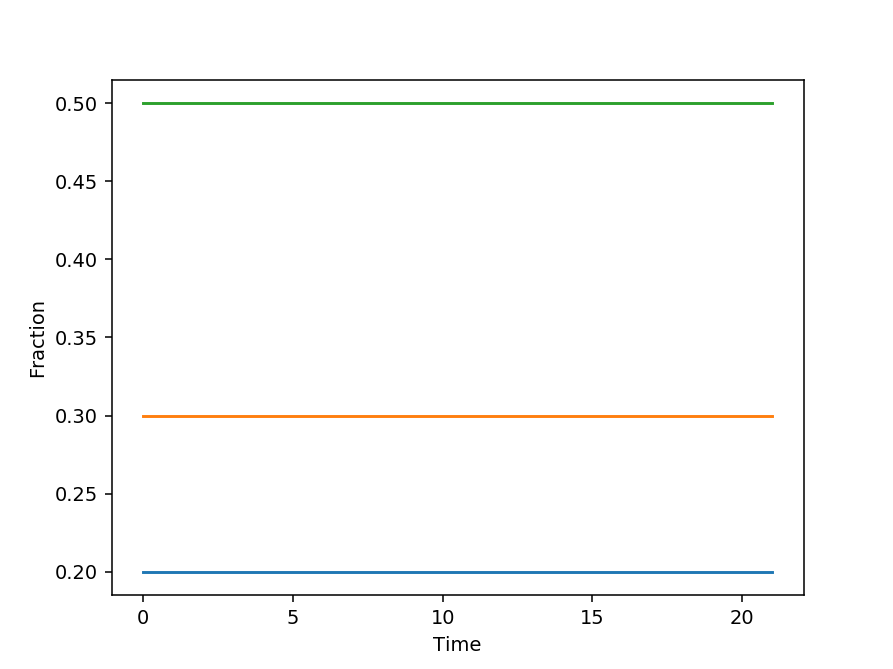

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# sums = f(yearlyContribution,years)
bestSolutionCombinations = [row[0] for row in bestSolution]
print(bestSolutionCombinations)

xs = [i for i in range(len(bestSolution))]
for i in range(len(bestSolutionCombinations[0])):
    ms = [combination[i] for combination in bestSolutionCombinations]
    plt.plot(xs,ms)

plt.xlabel('Time')
plt.ylabel('Fraction')
plt.show()

How does this solution compare to avalanche for various different debts and interest rates